# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import get_scorer_names
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

C:\Users\asiko\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Custom functions

In [2]:
#Downcasting int64 to reduce memory

def reduce_int_memory(df, columns_to_reduce=[]):
    """
    You have to specify data frame and columns as a list
    
    """

    downcast_int_dict = {'int8': [-128, 127], 'int16': [-32768, 32767]}


    for column in df.loc[:, columns_to_reduce].columns:
        max_val = df[column].max()
        min_val = df[column].min()


        for key in downcast_int_dict.keys():
            if min_val > downcast_int_dict[key][0] and max_val < downcast_int_dict[key][1]:
                df[column] = df[column].astype(key)
                break
        
    
    return df

In [3]:
#change data types

def reduce_memory(df):
    
    memory_before_change = round(df.memory_usage(deep=True).sum()/1000000, 2)
    #Date
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    

    #Only for Sales_df
    if 'Dept' in df.columns:
        df = reduce_int_memory(df, columns_to_reduce=['Store', 'Dept'])
        df.set_index('Date', inplace=True)
    
    #Floats
    columns_with_float = df.select_dtypes(include=[np.float64]).columns

    for column in columns_with_float:
        df[column] = df[column].astype('float32')

#     df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

    memory_after_change = round(df.memory_usage(deep=True).sum()/1000000, 2)
    print(f"Memory reduced from {memory_before_change} MB to {memory_after_change} MB")
    #memory usage reduced from 13.3 MB to 6.0
    
    return df

In [4]:
def do_subplot_w_ts(df, ncol=2, nrow=3, column_to_filter='', x='', y='' ):
    """
    ***It is very important to specify ncols and nrow
    You have to check first how many unique values contains your column to filter
    ncols * nrow >= amount of unique values
    
    ***If you want to plot Date and it is in index thet write x='index'
    """
    values_to_print = list(df[column_to_filter].unique())
    
    if len(values_to_print) <= ncol*nrow:
        fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(20, nrow*5), sharex=False, sharey=False)
    
    
        for val, ax in zip(values_to_print, axes.flat):
            ax.title.set_text(f'Graph for Dept:  {val}')
            
            if x=='index':
                sns.lineplot(data = df[df[column_to_filter]==val], x=df[df[column_to_filter]==val].index, y=y, ax=ax)
            else:  
                sns.lineplot(data = df[df[column_to_filter]==val], x=x, y=y, ax=ax)
            
        return plt.show()
    else: return print('You have to increase ncol or nrow, your number is too small')


In [5]:
def plot_barplot_countplot(kind, df, x, y = '', title=''):
    """
    kind - barplot ('bar') or countplot ('count')
    """
    
    plt.figure(figsize=(18,7))
    plt.xticks(rotation=45)
    
    if kind =='bar':
        
        ax = sns.barplot(data = df, x = x, y=y)
    else:
        ax = sns.countplot(data = df, x = x)
        
    ax.set_title(title)
    plt.show()

In [6]:
def create_features_from_date(df):
    """
    date has to be in index
    """
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.isocalendar().week
    
    return df
    

In [7]:
def train_test_time_ser(df, perc_of_test=0.2):
    """
    Date has to be index
    """
    weeks_to_cut = round(df.index.nunique()*perc_of_test)
    date_to_filter = df.index.unique().sort_values(ascending = False)[:weeks_to_cut].min()
    train = df.loc[df.index < date_to_filter]
    test = df.loc[df.index >= date_to_filter]
    
    fig, ax = plt.subplots(figsize=(20,5))
    sns.lineplot(data = train, x=train.index, y='Weekly_Sales', ax=ax, label='Training set')
    sns.lineplot(data = test, x=test.index, y='Weekly_Sales', ax=ax, label='Test set')
    ax.axvline(date_to_filter, color='black', ls='--')
    ax.legend(['Training set', 'Test set'])
    print(plt.show())
    
    return train, test

In [8]:
def merge_features(df):
    """
    Function used to merge features_df
    """

    df = df.reset_index().merge(features_df.iloc[:,:-1],
                           how='left',
                           on=['Date', 'Store'])\
                           .set_index('Date')
#                            .fillna(0)
    
    return df

In [9]:
def add_lag_features(df):
    
#     df['Sales_next_week'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(-1)
    df['lag_sales_1'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(1)
    df['lag_sales_4'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(4)
    # df['rolling_4'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].rolling(4).mean().reset_index(level=0, drop=True).reset_index(level=0, drop=True)
    
    return df


In [10]:
def split_test_data (df, type='regression', testing_size=0.2):
    
    """
    type = regression, classic train_test_split from sklearn
    type = time_series, splitted by date, use custom function called 'train_test_time_ser'
    
    """
    if type=='regression':
        
        from sklearn.model_selection import train_test_split
        sales_train, sales_test = train_test_split(df, test_size=testing_size, stratify=df.IsHoliday)
        
    else: sales_train, sales_test = train_test_time_ser(df, perc_of_test = testing_size)
    
    
    return sales_train, sales_test

In [11]:
def encode_data(df):
    
    #Encode binary column
    holiday_map = {True: 1, False: 0}
    df['IsHoliday'] = df['IsHoliday'].map(holiday_map)
    
    #Encode categorical columns
    df = pd.get_dummies(df)
    
    return df

In [12]:
def save_model(model, name):
    
    import pickle

    with open(name, 'wb') as f:
        pickle.dump(model, f)


In [13]:
def load_model(name_model):
    import pickle
    with open(name_model, 'rb') as f:
        model = pickle.load(f)
    return model

In [14]:
def get_r2(model, X_train, X_test, y_test, y_train):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print('R^2 test set: %.2f' % r2_score(y_test, y_pred_test))
    print('R^2 training set: %.2f' % r2_score(y_train, y_pred_train))

In [15]:
def print_feature_importance_xgb(model):
    
    #Feature importance
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X_test.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.title("Feature Importance")
    print(plt.show())

In [16]:
def transform_mrkd_df(df):
    # make sure that data is sorted
    df = df.reset_index().sort_values(by=['Store', 'Dept', 'Date']).set_index("Date")
    
    #add time features
    df = create_features_from_date(df)

    
    #add lag features
    df = add_lag_features(df)
    
    #add features from csv file
    df = df.query('IsHoliday==True')\
            .reset_index()\
            .groupby(['Date', 'Store']).sum()\
            .reset_index()\
            .drop(["Dept", "IsHoliday"], axis=1)\
            .set_index("Date")
    
    df = merge_features(df)
    
    filter_col = [col for col in df if col.startswith('Mark')]
    
    #filter days with missing values
    df['Markdown_total'] = df[filter_col].sum(axis=1)
    df = df.query('Markdown_total>0')
    
    
    return df

# 1. Reading data

In [17]:
file_names = ["Features data set", 'sales data-set', 'stores data-set']

features_df = pd.read_csv (f".//Data//{file_names[0]}.csv")
sales_df = pd.read_csv (f".//Data//{file_names[1]}.csv")
stores_df = pd.read_csv (f".//Data//{file_names[2]}.csv")

In [22]:
sales_df.info()
#OK, any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [23]:
#let's the stores
print(stores_df.head(5))
print("\n")
print(stores_df.info())
#OK, any missing values

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


In [24]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [ ]:
#columns with Markdown are mostly missing - It could be possible in some cases:
#1) some stores doesnt need to do markdowns if they sell really good or have not enough goods on stock
#2) there is no reason to do all 5 markdowns every day - maybe one of them is enough

#Information from dataset describtion: "MarkDown1-5 - anonymized data related to promotional markdowns. 
#MarkDown data is only available after Nov 2011, and is not available for all stores all the time.""


#It is not available on Dept and store level, that's why I will drop it


In [18]:
#1) Droping Markdownn
[features_df.drop(col, axis=1, inplace=True) for col in features_df.columns if col.startswith('Mark')]

#2) changing data types
sales_df = reduce_memory(sales_df)
features_df = reduce_memory(features_df)

Memory reduced from 38.78 MB to 6.32 MB
Memory reduced from 0.88 MB to 0.27 MB


In [19]:
#Let's check missing values CPI and Unemployment - maybe the information is already in another row
feat_temp = features_df[features_df['CPI'].isna()].loc[:,['Date', 'Store']].groupby(by='Date').count()
print(feat_temp)
#it is not, 13 NaN values

print(f"  Max sales data {sales_df.index.max()} vs min missing value {feat_temp.index.min()} \n")
print(f" {features_df['Date'].min()} vs sales data {sales_df.index.min()}")

#conclusion - missing values are OK, I don't have sales data at this date so I don't need the data so far

            Store
Date             
2013-05-03     45
2013-05-10     45
2013-05-17     45
2013-05-24     45
2013-05-31     45
2013-06-07     45
2013-06-14     45
2013-06-21     45
2013-06-28     45
2013-07-05     45
2013-07-12     45
2013-07-19     45
2013-07-26     45
  Max sales data 2012-10-26 00:00:00 vs min missing value 2013-05-03 00:00:00 

 2010-02-05 00:00:00 vs sales data 2010-02-05 00:00:00


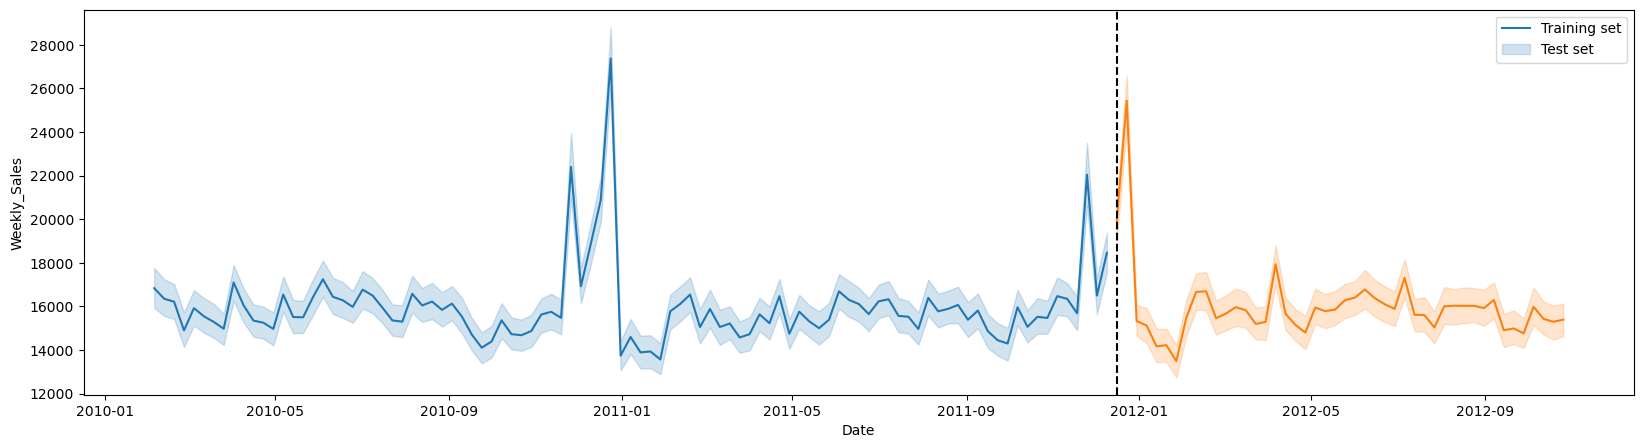

None


In [20]:
#split data into train and test

#I have 2 possibilities:
#- split data based on time - train will be e.g 2 years and last dates as a test
#- split as normal with sklearn like in regression problem

#I tested both and I will keep time series - because lag features have are the most influencial features and 
# it doesnt make sense if I split data randomly
sales_train, sales_test = split_test_data(sales_df, type='time_series', testing_size=0.32)
#not usual testing size - I want to have one sales pick in test set

# 2. Exploring data (EDA)

In [21]:
#Let's check features
print(features_df.sample(10))
print("\n")

print(features_df.loc[features_df.duplicated(subset=['Store', 'Date'])])
#no duplicated values at all

      Store       Date  Temperature  Fuel_Price         CPI  Unemployment  \
5951     33 2012-07-13    97.599998       3.723  130.682999         7.147   
2924     17 2010-04-30    43.820000       2.941  126.380569         6.635   
7527     42 2011-05-06    73.559998       4.193  129.044434         8.494   
1268      7 2013-06-21    52.160000       3.736         NaN           NaN   
3268     18 2013-06-07    66.550003       3.660         NaN           NaN   
2133     12 2012-08-10    95.910004       3.811  130.756165        10.926   
3664     21 2010-07-23    87.169998       2.608  210.892136         8.099   
1026      6 2012-04-27    71.500000       3.814  223.225494         5.964   
4183     23 2013-07-12    72.849998       3.645         NaN           NaN   
4110     23 2012-02-17    27.010000       3.703  137.258316         4.261   

      IsHoliday  
5951      False  
2924      False  
7527      False  
1268      False  
3268      False  
2133      False  
3664      False  
1026    

In [24]:
print(sales_train.head())
print("\n")

#check if there is no duplicated values
print(sales_train.reset_index().loc[sales_train.reset_index().duplicated(subset=['Store', 'Dept', 'Date', 'Weekly_Sales'])])
#no duplicated values at all
print("\n")

#let's check if there is more rows for store, dept for same Date
print(sales_train.reset_index().loc[sales_train.reset_index().duplicated(subset=['Store', 'Dept', 'Date'])])
#it is fine
print("\n")
#let's check missing values
sales_train.info()

            Store  Dept  Weekly_Sales  IsHoliday
Date                                            
2010-02-05      1     1  24924.500000      False
2010-02-12      1     1  46039.488281       True
2010-02-19      1     1  41595.550781      False
2010-02-26      1     1  19403.539062      False
2010-03-05      1     1  21827.900391      False


Empty DataFrame
Columns: [Date, Store, Dept, Weekly_Sales, IsHoliday]
Index: []


Empty DataFrame
Columns: [Date, Store, Dept, Weekly_Sales, IsHoliday]
Index: []


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285089 entries, 2010-02-05 to 2011-12-09
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         285089 non-null  int8   
 1   Dept          285089 non-null  int8   
 2   Weekly_Sales  285089 non-null  float32
 3   IsHoliday     285089 non-null  bool   
dtypes: bool(1), float32(1), int8(2)
memory usage: 4.1 MB


In [25]:
sales_train.describe()

Store           Dept   Weekly_Sales
count  285089.000000  285089.000000  285089.000000
mean       22.180231      44.167183   15972.051758
std        12.780103      30.422383   22735.925781
min         1.000000       1.000000   -4988.939941
25%        11.000000      18.000000    2133.610107
50%        22.000000      37.000000    7676.729980
75%        33.000000      72.000000   20183.179688
max        45.000000      99.000000  693099.375000

weekly_sales below 0 looks weird, but it could be possible for some departments, if there was more returns than sales or inventory loss

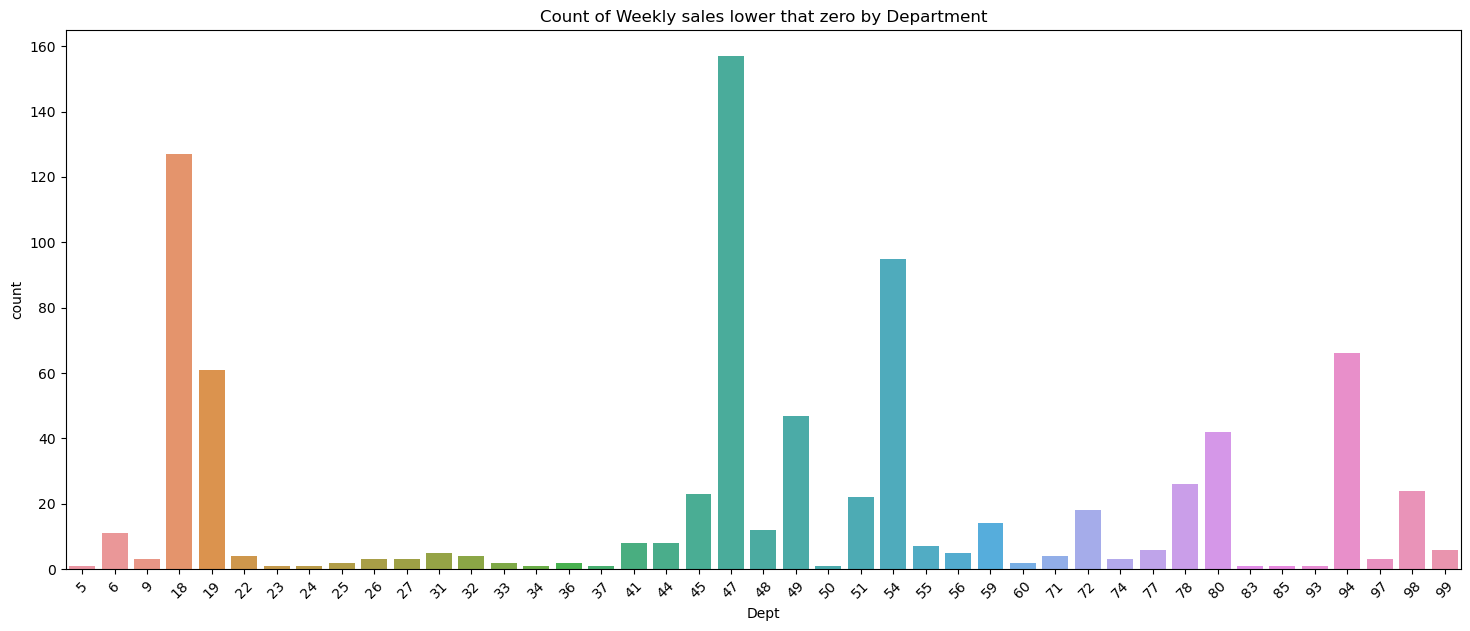

In [26]:
plot_barplot_countplot(kind='count', 
                       df = sales_train[sales_train['Weekly_Sales'] < 0],
                       x='Dept', title='Count of Weekly sales lower that zero by Department')

In [19]:
#dept 18, 47, 54, 19, 94 - top dept with highest count of sales below 0

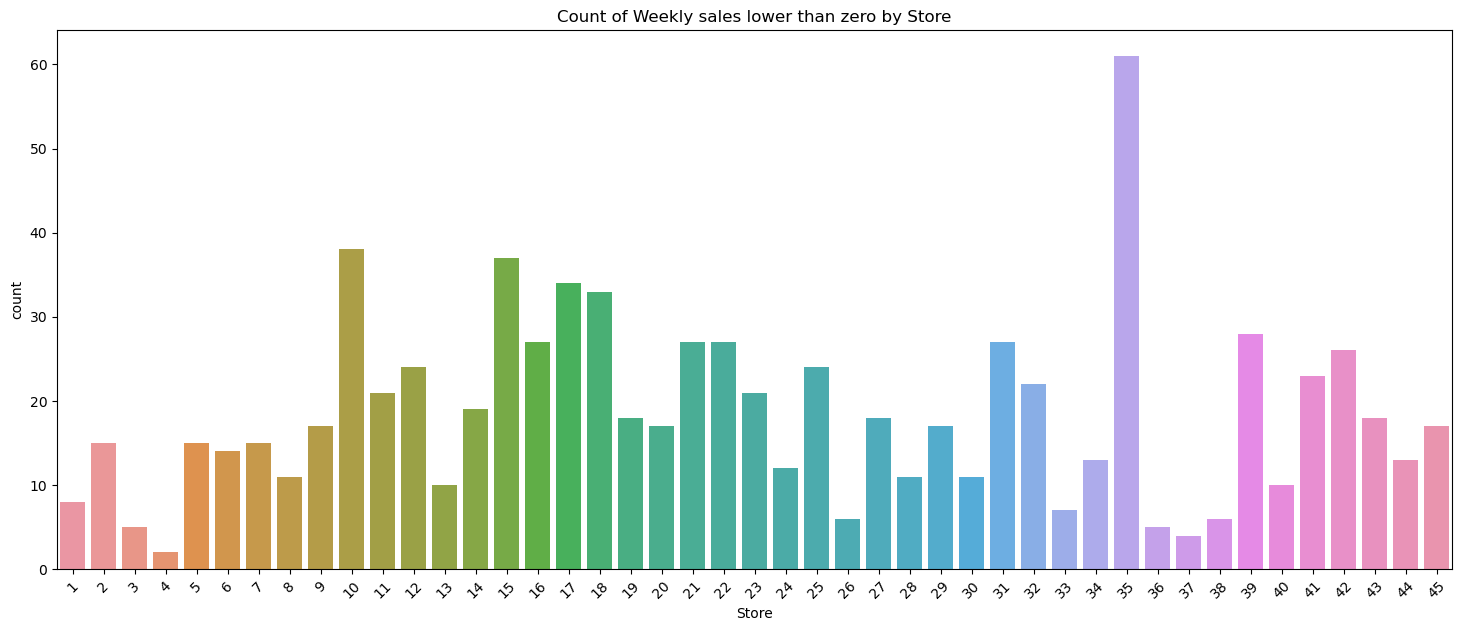

In [27]:
plot_barplot_countplot(kind='count', 
                       df = sales_train[sales_train['Weekly_Sales'] < 0],
                       x='Store', title='Count of Weekly sales lower than zero by Store')

In [21]:
#some stores with higher counts, but generally speaking it looks OK

In [22]:
# Conclusion - It looks normal, and I won't change data - it can be possible, that some dept has minus values 
# If I could, I would ask businnes what is the reason

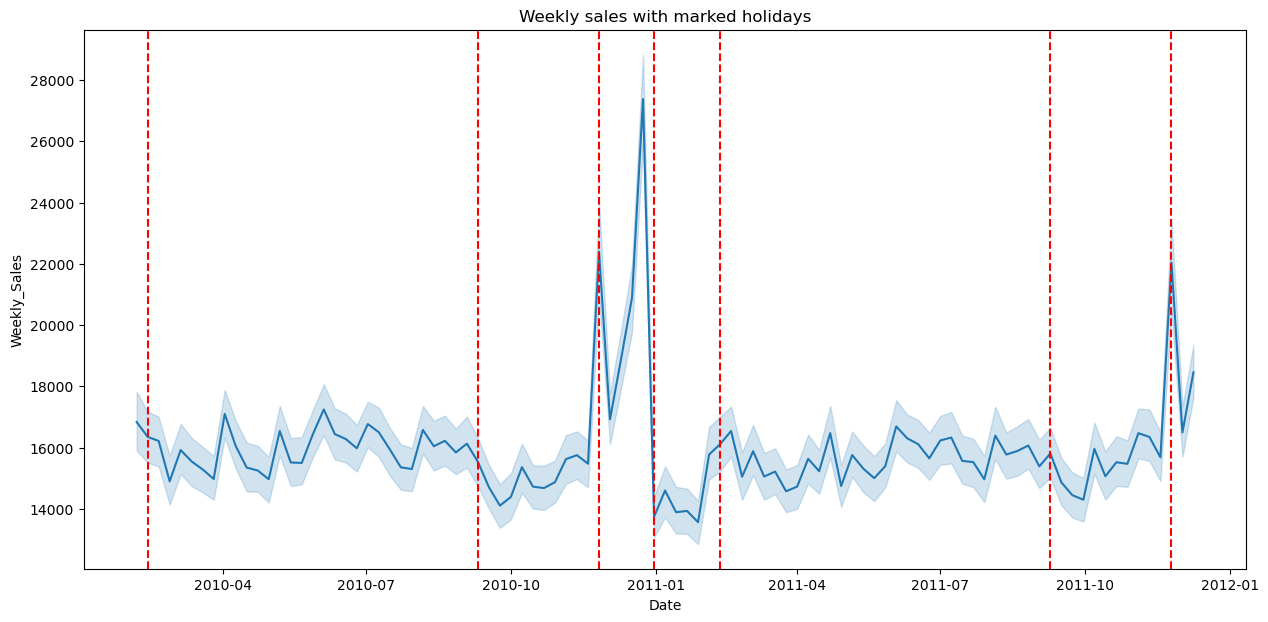

In [28]:
#get holiday = true unique values
holiday_list = list(sales_train[sales_train['IsHoliday']==True].index.unique())

plt.figure(figsize=(15,7))
sns.lineplot(data = sales_train, x=sales_train.index, y='Weekly_Sales')
plt.title('Weekly sales with marked holidays')
for holiday in holiday_list:
    plt.axvline(x=holiday, c='r', ls='--')

In [25]:
#conclusion:
# - peaks at the end of the year - christmas time
# - peaks are highly connected with holidays

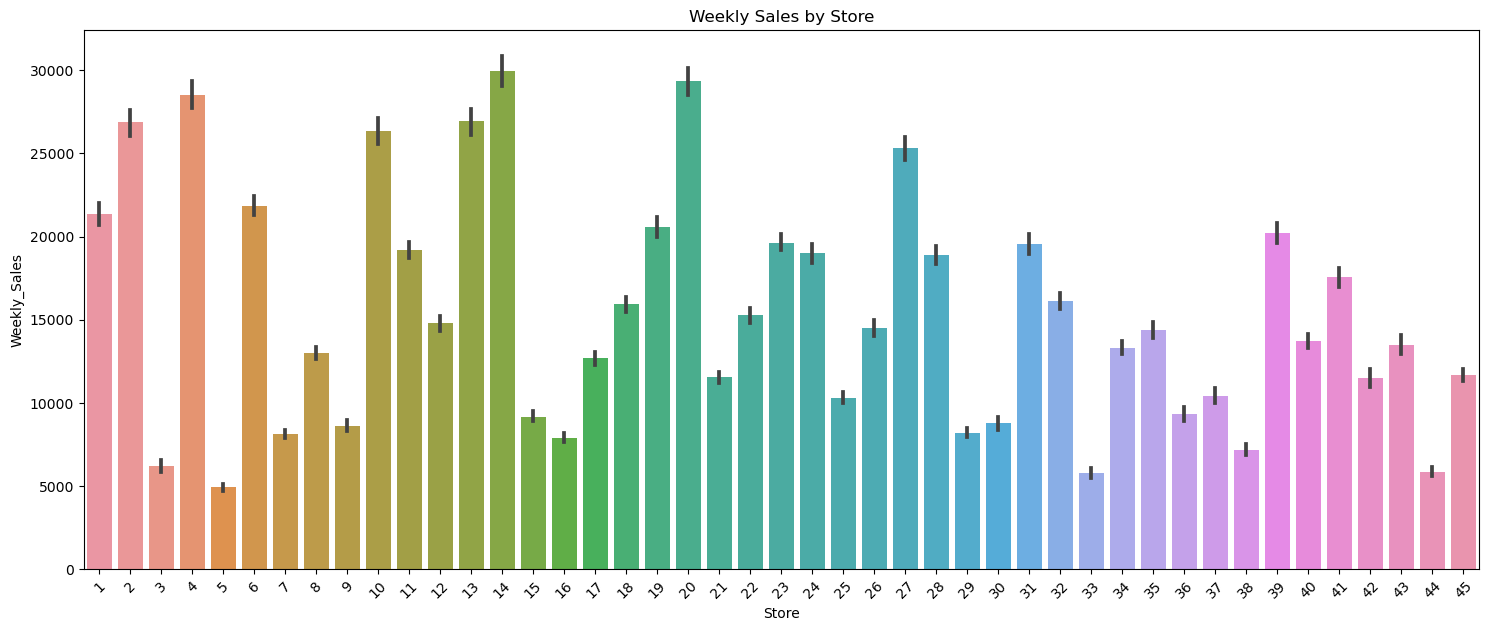

In [29]:
#Let's check stores
plot_barplot_countplot(kind='bar', df=sales_train, x='Store', y='Weekly_Sales', title='Weekly Sales by Store')

In [27]:
#conclusion: some stores performes much better than others - maybe I could group it later

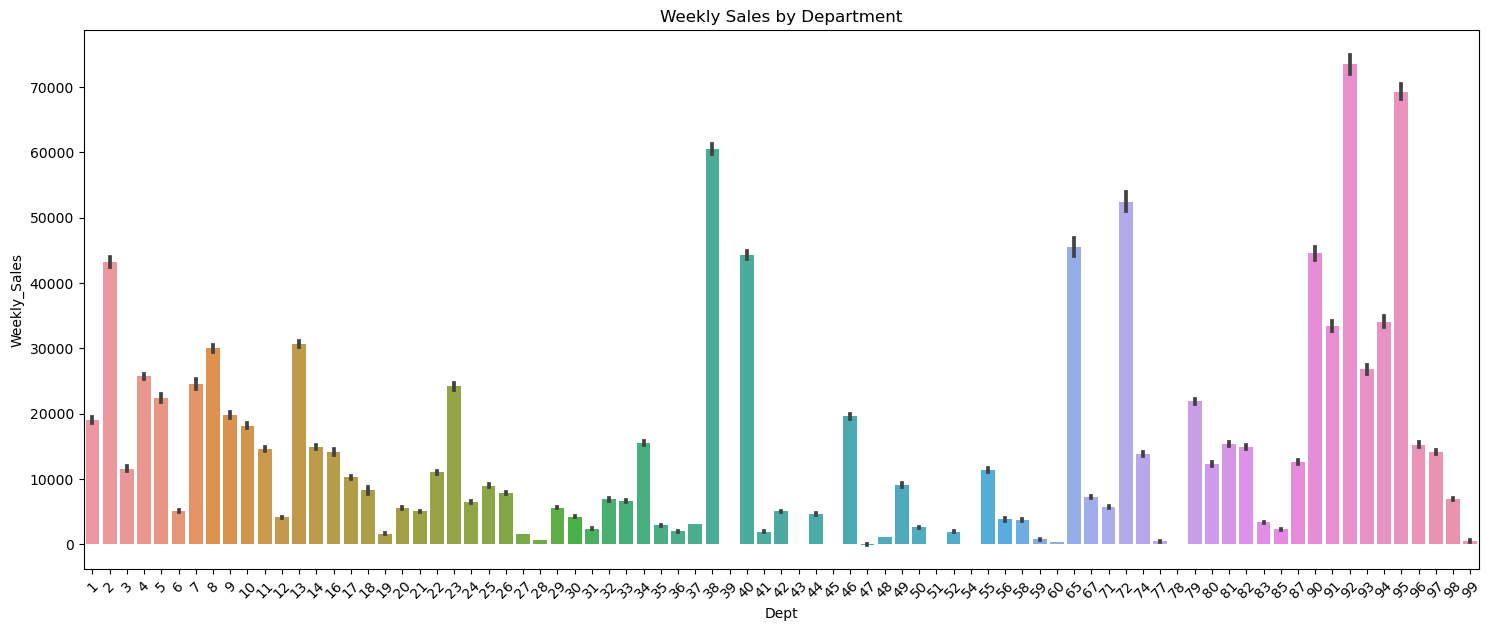

In [30]:
plot_barplot_countplot(kind='bar', df=sales_train, x='Dept', y='Weekly_Sales', title='Weekly Sales by Department')

In [29]:
#Conclusion - huge different between departments

In [31]:
#Let's check top 5 and flop 5

dept_top_5 = pd.pivot_table(data = sales_train, values='Weekly_Sales', columns='Dept' )\
            .T\
            .sort_values(by='Weekly_Sales', ascending=False)\
            .head(5)



dept_flop_5 = pd.pivot_table(data = sales_train, values='Weekly_Sales', columns='Dept' )\
            .T\
            .sort_values(by='Weekly_Sales', ascending=False)\
            .tail(5)


print(dept_top_5)
print(dept_flop_5)

      Weekly_Sales
Dept              
92    73461.054688
95    69314.507812
38    60496.226562
72    52443.613281
65    45499.929688
      Weekly_Sales
Dept              
45       22.969692
78        7.809521
39        6.486667
43        1.470000
47      -12.962454


In [31]:
#it is huge diffrence between Dept, i think some of dept are not available whole year - it is rather not possible to generete weekly sales so low

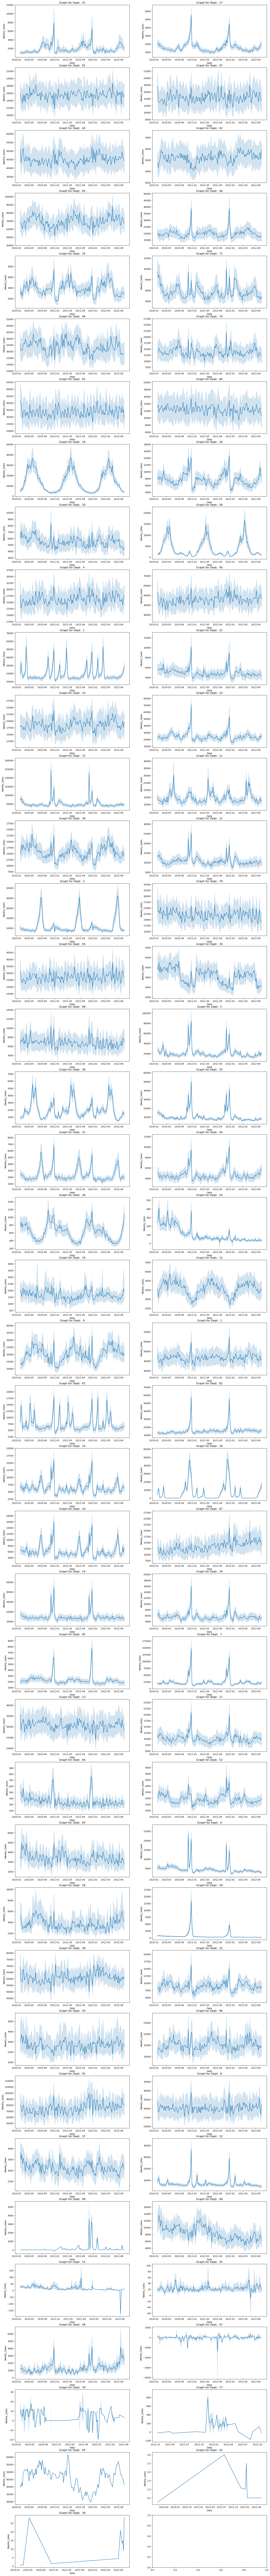

In [32]:
do_subplot_w_ts(df = sales_train, ncol=2, nrow = 41, column_to_filter='Dept', x='index', y='Weekly_Sales')

In [33]:
#Conclusion - There are 3 main groups of departments:
#1) sells whole year e.g 87, 90
#2) sells whole year with great peak at the end of year at christmas e.g 82, 85, 46
#3) sells saisonally - maybe ice creams e.g 16

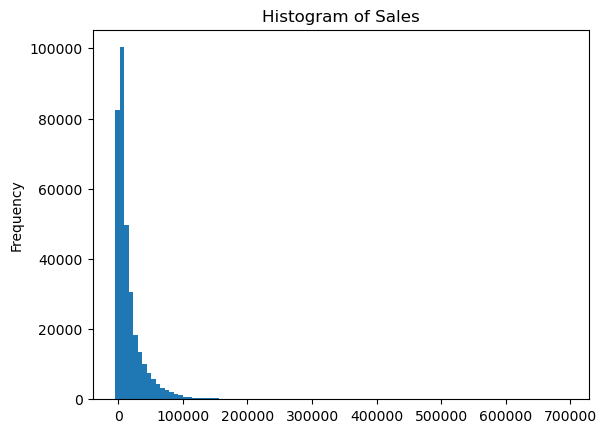

In [34]:
#check hist
ax = sales_train['Weekly_Sales'].plot(kind='hist',
                                   bins=100,
                                   title='Histogram of Sales')

In [35]:
#it is not normal distribution, let's see without outliers

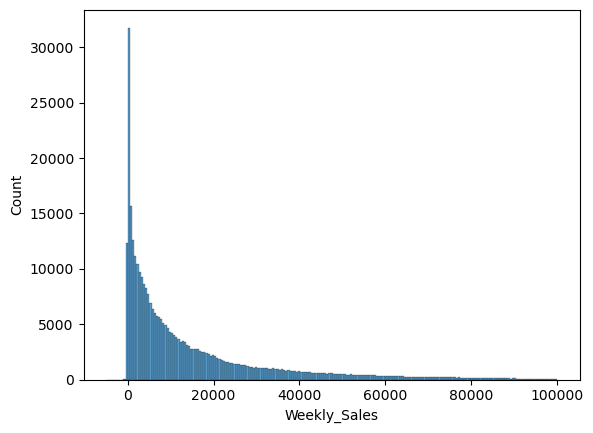

In [36]:
sns.histplot(data = sales_train.query('Weekly_Sales<100000'), x='Weekly_Sales')
plt.show()

# 3. Add features

In [32]:
#Join from features.csv

sales_train = merge_features(sales_train)
sales_test = merge_features(sales_test)

#Join from stores.csv
sales_train = sales_train.reset_index().merge(stores_df, how='left', on='Store').set_index('Date')
sales_test = sales_test.reset_index().merge(stores_df, how='left', on='Store').set_index('Date')

In [33]:
# make sure that data is sorted properly
sales_train = sales_train.reset_index().sort_values(by=['Store', 'Dept', 'Date']).set_index("Date")
sales_test = sales_test.reset_index().sort_values(by=['Store', 'Dept', 'Date']).set_index("Date")

#Feature enngineering
sales_train = create_features_from_date(sales_train)
sales_test = create_features_from_date(sales_test)

sales_train = add_lag_features(sales_train)
sales_test = add_lag_features(sales_test)

# 4. Building models

In [42]:
#Prepare data

In [34]:
sales_train = encode_data(sales_train)
sales_test = encode_data(sales_test)

#split x, y
y_train = sales_train.loc[:,"Weekly_Sales"].ravel()
X_train = sales_train.loc[:,sales_train.columns !='Weekly_Sales']
y_test = sales_test.loc[:,"Weekly_Sales"].ravel()
X_test = sales_test.loc[:,sales_test.columns !='Weekly_Sales']

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(285089,) (285089, 20)
(136481,) (136481, 20)


In [35]:

def train_model(algo, X_train, y_train, X_test, y_test, param_grid=None, grid_type='Randomized'):
    steps = [('inputer', SimpleImputer()),
             ('scaler', MinMaxScaler()),
             ('model', algo)]
    clf = Pipeline(steps=steps)
    
    if param_grid is None:
        model = clf.fit(X_train, y_train)
    
    else:
        if grid_type == 'Randomized':
            
            clf = RandomizedSearchCV(estimator=clf, 
                               param_distributions=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs = -1,
                               return_train_score=True
                              )
        else:
            
            clf = GridSearchCV(estimator=clf, 
                               param_grid=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs = -1,
                               return_train_score=True
                              )

        if algo=='xgb':
            clf.fit(X_train, y_train, xgb__early_stopping_rounds=10)
        else:
            clf.fit(X_train, y_train)
        
        
        model = clf.best_estimator_

    score = model.score(X_test, y_test)
    return model, score

In [36]:
def test_algo(X_train, y_train, X_test, y_test, grid_type):
    

    algos = {
        "linearregression": {"algo": LinearRegression(), "params": None}, 
    #     "lasso": {"algo": Lasso(), "params": {"model__alpha": [0.001,0.01, 0.1,  0.7, 1],
    #                                          "model__fit_intercept":[True, False]}},
        "ridge": {"algo": Ridge(), "params": {"model__alpha": [0.001,0.01,  0.1,  0.7, 1],
                                              "model__solver":['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                                              "model__fit_intercept":[True, False]}},
        "rf": {"algo": RandomForestRegressor(), "params":{"model__n_estimators":[10, 50, 100, 500, 1000],
                                                          "model__max_depth":[2, 5, 10, 20, 40, 60, 100],
                                                          "model__max_features":["auto", "sqrt", "log2"],
                                                          "model__min_samples_split":np.linspace(0.01, 1.0, 20) 
                                                         }},
        "xgb": {"algo": XGBRegressor(), "params":{"model__max_depth":[2, 3, 5, 7, 10],
                                                  "model__n_estimators":[100, 500, 1000],
                                                  "model__learning_rate":[0.001, 0.01, 0.1, 0.3],
                                                  "model__colsample_bytree":[0.5,1],
                                                  "model__subsample": [0.6, 1]

                                                         }}
    }



    
    result_dict = {}
    for key in algos.keys():
        print(key)
        result = train_model(algos[key]['algo'], 
                             X_train, y_train, X_test, y_test, 
                             algos[key]['params'],grid_type)
        print(result[1], result[0])
        result_dict[key] = {"score": result[1], "model": result[0]}
    
    return result_dict
    


In [37]:
def get_best_model(result_dict):
    
    max_value=0
    for k in result_dict.keys():
        if result_dict[k]['score'] > max_value:
            max_value = result_dict[k]['score']
            algorithm = k

    print(f"Score is: {max_value}")
    print(f" Type of algorithm is: {algorithm}")
    #wyciągniecie modelu
    best_model = result_dict[algorithm]['model']
    return best_model

In [56]:
def get_model(X_train, y_train, X_test, y_test, grid_type='Grid_search', loading_model='no', model_name = "main_model"):
    """
    load_model:
    - if = yes, then model will be loaded. In this case you have to specify model_name
    - if = no, model will be created and save
    
    grid_type:
    - you can specify 'Grid_search' or 'Randomized'
    """
    if loading_model == 'no':
        result_dict = test_algo(X_train, y_train, X_test, y_test, grid_type=grid_type)
        model = get_best_model(result_dict)
        get_r2(model, X_train, X_test, y_test, y_train)
        save_model(model = model, name = model_name)
    else:
        model = load_model(model_name)
    
    return model

In [59]:
model = get_model(X_train, y_train, X_test, y_test, grid_type='Randomized',loading_model='yes', model_name = 'main_model')

In [61]:
get_r2(model, X_train, X_test, y_test, y_train)

R^2 test set: 0.94
R^2 training set: 0.99


In [62]:
#Conclusion: Model is not overfitted

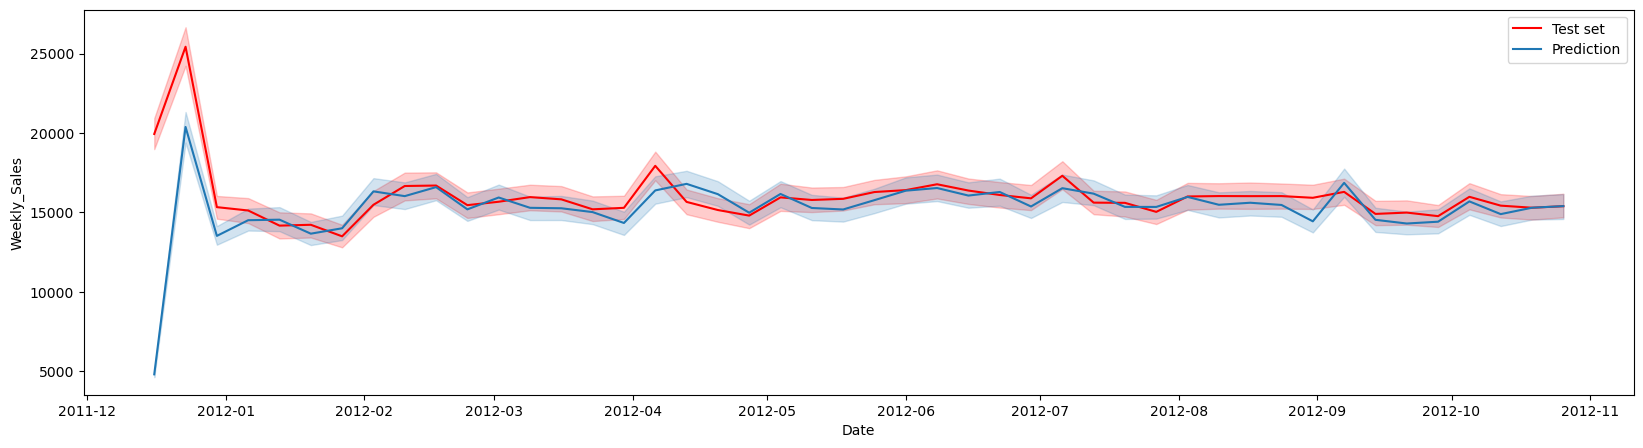

None


In [63]:
sales_test['prediction'] = model.predict(X_test)
fig = plt.subplots(figsize=(20,5))
sns.lineplot(data = sales_test, x=sales_test.index, y='Weekly_Sales', label='Test set', c='r' )
sns.lineplot(data = sales_test, x=sales_test.index, y='prediction', label='Prediction')

# ax.axvline(date_to_filter, color='black', ls='--')
# ax.legend(['Model', 'Test set'])
print(plt.show())

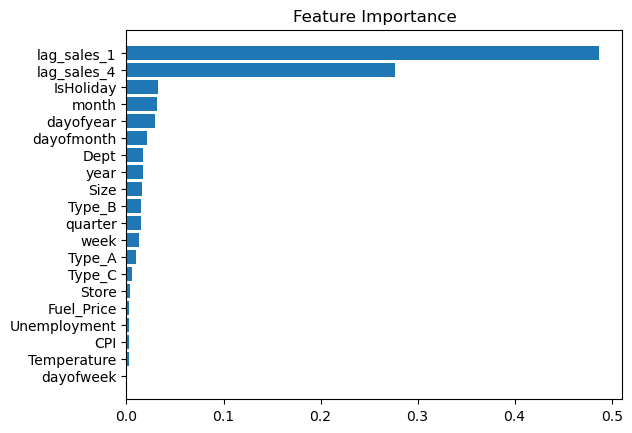

None


In [64]:
print_feature_importance_xgb(model[2])

In [65]:
#Let's drop 10 features and see impact to model
sorted_idx = model[2].feature_importances_.argsort()
columns_to_drop = X_test.columns[sorted_idx][:10]
[X_train.drop(col, axis=1, inplace=True) for col in columns_to_drop]
[X_test.drop(col, axis=1, inplace=True) for col in columns_to_drop]

C:\Users\asiko\AppData\Local\Temp\ipykernel_4728\1100428252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  [X_train.drop(col, axis=1, inplace=True) for col in columns_to_drop]
C:\Users\asiko\AppData\Local\Temp\ipykernel_4728\1100428252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  [X_train.drop(col, axis=1, inplace=True) for col in columns_to_drop]
C:\Users\asiko\AppData\Local\Temp\ipykernel_4728\1100428252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

[None, None, None, None, None, None, None, None, None, None]

In [67]:
model_reduced_feat = get_model(X_train, y_train, X_test, y_test, grid_type='Randomized',loading_model='yes', model_name = 'main_model_reduced_features')

In [68]:
get_r2(model, X_train, X_test, y_test, y_train)
#Conclusion - with less features model performs better, not huge difference

R^2 test set: 0.95
R^2 training set: 0.99


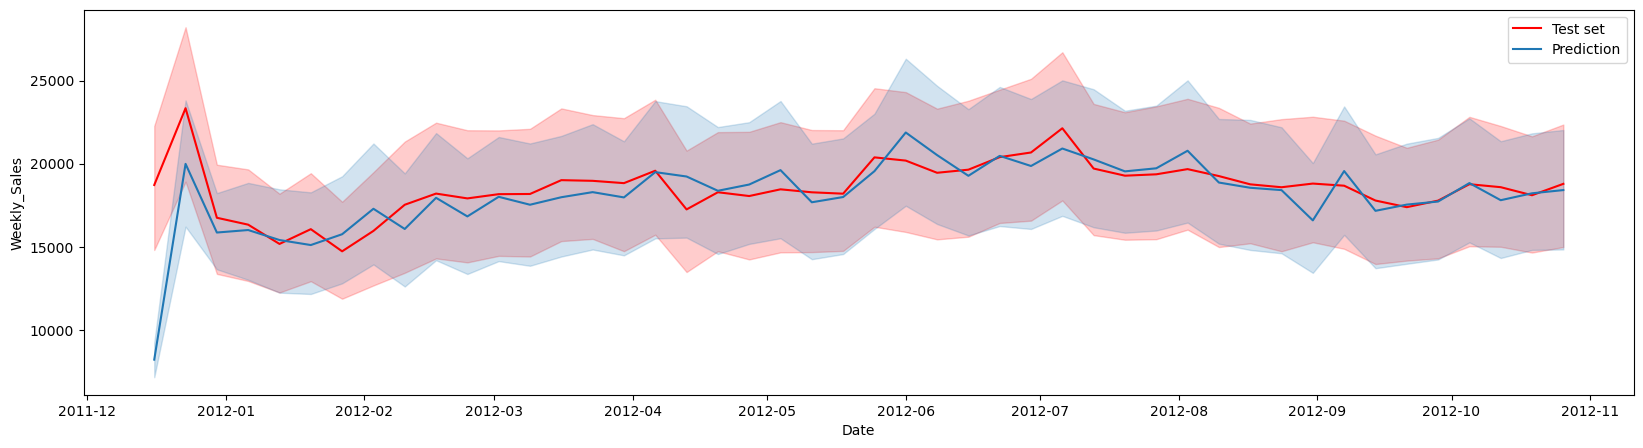

None


In [69]:
sales_test['prediction'] = model_reduced_feat.predict(X_test)
fig = plt.subplots(figsize=(20,5))
sns.lineplot(data = sales_test.query("Dept==10"), x=sales_test.query("Dept==10").index, y='Weekly_Sales', label='Test set', c='r' )
sns.lineplot(data = sales_test.query("Dept==10"), x=sales_test.query("Dept==10").index, y='prediction', label='Prediction')

# ax.axvline(date_to_filter, color='black', ls='--')
# ax.legend(['Model', 'Test set'])
print(plt.show())